## Plot effects of inserts on mRNA levels



### Load libraries and define analysis-specific parameters

In [1]:
library(Biostrings)
library(tidyverse)
library(rasilabRtemplates)

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min


Loading required package: S4Vectors

Loading required package: stats4


Attaching package: ‘S4Vectors’


The following objects are masked from ‘package:base’:

    expand.grid, I, unname


Loading required package: IRanges

Loading required package: XVector

Loading required package: GenomeInfoDb


Attaching package: ‘Biostrings’


The following object is masked from ‘package:base’:



### Read in barcode counts

In [21]:
barcode_counts <- read_tsv("../tables/sample_insert_barcode_counts.tsv.gz") %>% print 

timecourse_counts <- barcode_counts %>%
  # Select only timecourse samples
  filter(!str_detect(sample_name, "rna")) %>%
  # Remove "stall4control4_" from sample names
  mutate(sample_name = str_remove(sample_name, "stall4control4_")) %>%
  # Create a time column based on sample_name 
  mutate(time = as.numeric(str_extract(sample_name, "(?<=.).+"))) 

timecourse_counts  

Rows: 27840 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): sample_name, cellline
dbl (5): pool, insert_num, barcode_num, barcode_count, linkage_count

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


# A tibble: 27,840 × 7
   sample_name         cellline  pool insert_num barcode_num barcode_c…¹ linka…²
   <chr>               <chr>    <dbl>      <dbl>       <dbl>       <dbl>   <dbl>
 1 stall4control4_grna K562         6          5       12338        2551       1
 2 stall4control4_grna HeLa         5          4        7889        1779     303
 3 stall4control4_grna HeLa         5          5        7888        1628     431
 4 stall4control4_grna HeLa         5          2        7909        1107     223
 5 stall4control4_grna K562         6          3       10487        1041     333
 6 stall4control4_grna HeLa         5          3        7899        1000     254
 7 stall4control4_grna HCT116       4          7        7845         970       1
 8 stall4control4_grna HeLa         5          5        8016         941     151
 9 stall4control4_grna K562         6          5       11819         938       2
10 stall4control4_grna HCT116       4          5        7208         934       2
# … w

sample_name,cellline,pool,insert_num,barcode_num,barcode_count,linkage_count,time
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
t0,HeLa,5,3,10186,2946,1,0
t0,NA,2,5,3369,2260,1,0
t0,HEK293T,3,7,3617,1520,279,0
t0,HEK293T,3,7,3630,1346,243,0
t0,HEK293T,3,7,3640,1343,228,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
t6,K562,6,2,11941,1,1,6
t6,K562,6,5,12003,1,1,6
t6,K562,6,7,12104,1,1,6


### Read insert annotations

In [6]:
insert_annotations <- read_tsv("../../pool4_linkage/annotations/insert_annotations/stall4control4_linkage.tsv") %>% 
  # Rename initial insert sequence as "insert_seq" 
  dplyr::rename(insert_seq = rev_comp) %>%
  print()

Rows: 8 Columns: 8
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (5): group, insert_name, seq, rev_comp, insert_type
dbl (3): insert_num, pair, frame

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


# A tibble: 8 × 8
  group insert_name seq                      inser…¹ inser…² inser…³  pair frame
  <chr> <chr>       <chr>                    <chr>   <chr>     <dbl> <dbl> <dbl>
1 human PS8         CGATGGCGATGGCGATGGCGATG… CCATCG… control       7     1     2
2 human RH8         ATGGCGATGGCGATGGCGATGGC… CGCCAT… stall         6     1     0
3 human FQ8         CTGAAACTGAAACTGAAACTGAA… TTTCAG… control       5     3     2
4 human SF8         GAAACTGAAACTGAAACTGAAAC… AGTTTC… stall         4     3     0
5 human QS8         ACTTTGACTTTGACTTTGACTTT… CAAAGT… control       3     2     2
6 human VK8         TTTGACTTTGACTTTGACTTTGA… GTCAAA… stall         2     2     0
7 human SKVF4       GTCAAAGTCAAAGTCAAAGTCAA… AGCAAA… control       1     4    NA
8 human SVKF4       GAATTTCACCGAAAACTTTACAC… AGCGTC… stall         0     4    NA
# … with abbreviated variable names ¹​insert_seq, ²​insert_type, ³​insert_num


### Function for bootstrap mRNA levels

In [7]:

calc_lfc_bootstrap <- function(data, indices) {
  d <- data[indices,]
  log2(sum(d$barcode_count))
}

### Calculate normalized mRNA levels per insert

- Pool 3 is HEK293T sample 
- Pool 4 is HCT116 as a negative control that was not spiked in
- Pool 5 is HeLa as spike in (we normalize by this)

- Pick only barcodes that are present in all time points


In [22]:

lfc_data <- timecourse_counts %>% 
  group_by(barcode_num) %>% 
  mutate(n_timepoints = dplyr::n()) %>% 
  ungroup() %>% 
  filter(n_timepoints == 6) %>% 
  filter(pool == 3|5) %>%  
  group_by(sample_name, time) %>% 
  mutate(barcode_count = barcode_count * 1e4 / sum(barcode_count[pool == 5])) %>% 
  ungroup() %>% 
  filter(pool == 3) %>% 
  select(-pool, -linkage_count) %>% 
  group_by(sample_name, time, insert_num) %>% 
  nest() %>%
  mutate(boot = map(data, function(df) boot::boot(data=df, statistic=calc_lfc_bootstrap, R=5000))) %>%
  # this gives mean and std.error of bootstrap
  mutate(stat = map(boot, broom::tidy)) %>% 
  # this gives all the replicates
  mutate(lfc = map(boot, function(x) x$t)) %>% 
  select(-data, -boot) %>%
  unnest(stat) %>% 
  group_by(insert_num) %>%
  mutate(statistic = statistic - statistic[time == 0]) %>%
  ungroup() %>%
  left_join(insert_annotations, by = "insert_num") %>%
  print()

# A tibble: 42 × 14
   sample_…¹ inser…²  time stati…³     bias std.e…⁴ lfc      group inser…⁵ seq  
   <chr>       <dbl> <dbl>   <dbl>    <dbl>   <dbl> <list>   <chr> <chr>   <chr>
 1 t0              7   0     0     -1.46e-3  0.0931 <dbl[…]> human PS8     CGAT…
 2 t0              5   0     0     -2.75e-4  0.0726 <dbl[…]> human FQ8     CTGA…
 3 t0              3   0     0     -1.08e-3  0.0793 <dbl[…]> human QS8     ACTT…
 4 t0              4   0     0     -2.81e-3  0.141  <dbl[…]> human SF8     GAAA…
 5 t0              6   0     0     -1.82e-2  0.204  <dbl[…]> human RH8     ATGG…
 6 t0              2   0     0     -4.86e-3  0.0926 <dbl[…]> human VK8     TTTG…
 7 t0              0   0     0     -3.59e-2  0.319  <dbl[…]> human SVKF4   GAAT…
 8 t0.5            7   0.5   0.214 -5.07e-3  0.0941 <dbl[…]> human PS8     CGAT…
 9 t0.5            5   0.5   0.277 -1.85e-3  0.0717 <dbl[…]> human FQ8     CTGA…
10 t0.5            3   0.5   0.245 -4.28e-3  0.0829 <dbl[…]> human QS8     ACTT…
# … with

### Plot mRNA of 8x dicodon inserts as a function of time

# A tibble: 36 × 14
   sample_…¹ inser…²  time stati…³     bias std.e…⁴ lfc      group inser…⁵ seq  
   <chr>       <dbl> <dbl>   <dbl>    <dbl>   <dbl> <list>   <chr> <chr>   <chr>
 1 t0              7   0     0     -1.46e-3  0.0931 <dbl[…]> human PS8     CGAT…
 2 t0              5   0     0     -2.75e-4  0.0726 <dbl[…]> human FQ8     CTGA…
 3 t0              3   0     0     -1.08e-3  0.0793 <dbl[…]> human QS8     ACTT…
 4 t0              4   0     0     -2.81e-3  0.141  <dbl[…]> human SF8     GAAA…
 5 t0              6   0     0     -1.82e-2  0.204  <dbl[…]> human RH8     ATGG…
 6 t0              2   0     0     -4.86e-3  0.0926 <dbl[…]> human VK8     TTTG…
 7 t0.5            7   0.5   0.214 -5.07e-3  0.0941 <dbl[…]> human PS8     CGAT…
 8 t0.5            5   0.5   0.277 -1.85e-3  0.0717 <dbl[…]> human FQ8     CTGA…
 9 t0.5            3   0.5   0.245 -4.28e-3  0.0829 <dbl[…]> human QS8     ACTT…
10 t0.5            4   0.5   0.245 -5.93e-3  0.136  <dbl[…]> human SF8     GAAA…
# … with

Warning message:
“Ignoring unknown parameters: width”


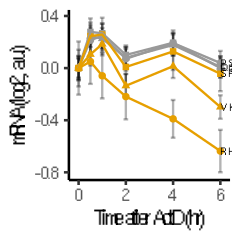

In [24]:
options(repr.plot.width=2, repr.plot.height=2)

plot_data <- lfc_data %>% filter(pair <= 3) %>% print 

plot_data %>% 
  ggplot(aes(x = time, y = statistic, 
             ymin = statistic - std.error, ymax = statistic + std.error,
             color = insert_type, group = insert_name, shape = as.factor(pair))) +
  geom_errorbar(width = 0.2, color = "black", alpha = 0.3) +
  geom_point(width=0.5, size=1.5) +
  geom_line() +
  scale_color_manual(values = cbPalette) +
  theme(legend.position = "none") +
  geom_text(aes(x = time, y = statistic, label = insert_name), 
            data = plot_data %>% filter(time == 6),
            color = "black", size = 2, hjust = 0) +
  labs(x = "Time after ActD (hr)", y = "mRNA (log2, a.u.)")

### Calculate bootstrap p-values for difference between stall and corresponding control at each time point

- Something is odd with this step. 

- It's nearly working, but seems the comparisons aren't quite being drawn appropriately (or at all) 

In [34]:
lfc_data %>%
  select(-statistic, -bias, -std.error, -insert_seq, -frame, -insert_num) %>%
  # Remove SVKF for now, since we don't have it's corresponding control
  filter(!str_detect(insert_name, "SVKF")) %>% 
  group_by(pair, time) %>%
  mutate(insert_name = insert_name[insert_type == "stall"]) %>% 
  pivot_wider(names_from = insert_type, values_from = lfc) %>% 
  unnest(control, stall) %>% 
  group_by(pair) %>% 
  mutate(control = control - mean(control[time == 0])) %>% 
  mutate(stall = stall - mean(stall[time == 0])) %>% 
  mutate(effect = if_else(stall > control, T, F)) %>% 
  group_by(sample_name, time, insert_name, pair) %>% 
  summarize(p = sum(effect) / dplyr::n()) %>% 
  ungroup() %>% print 

Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(control, stall))`, with `mutate()` if needed”
`summarise()` has grouped output by 'sample_name', 'time', 'insert_name'. You
can override using the `.groups` argument.


# A tibble: 18 × 5
   sample_name  time insert_name  pair     p
   <chr>       <dbl> <chr>       <dbl> <dbl>
 1 t0            0   RH8             1    NA
 2 t0            0   SF8             3    NA
 3 t0            0   VK8             2    NA
 4 t0.5          0.5 RH8             1    NA
 5 t0.5          0.5 SF8             3    NA
 6 t0.5          0.5 VK8             2    NA
 7 t1            1   RH8             1    NA
 8 t1            1   SF8             3    NA
 9 t1            1   VK8             2    NA
10 t2            2   RH8             1    NA
11 t2            2   SF8             3    NA
12 t2            2   VK8             2    NA
13 t4            4   RH8             1    NA
14 t4            4   SF8             3    NA
15 t4            4   VK8             2    NA
16 t6            6   RH8             1    NA
17 t6            6   SF8             3    NA
18 t6            6   VK8             2    NA
